# Prediction of sales

### Problem Statement
This dataset represents sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store are available. The aim is to build a predictive model and find out the sales of each product at a particular store.

|Variable|Description|
|: ------------- |:-------------|
|Item_Identifier|Unique product ID|
|Item_Weight|Weight of product|
|Item_Fat_Content|Whether the product is low fat or not|
|Item_Visibility|The % of total display area of all products in a store allocated to the particular product|
|Item_Type|The category to which the product belongs|
|Item_MRP|Maximum Retail Price (list price) of the product|
|Outlet_Identifier|Unique store ID|
|Outlet_Establishment_Year|The year in which store was established|
|Outlet_Size|The size of the store in terms of ground area covered|
|Outlet_Location_Type|The type of city in which the store is located|
|Outlet_Type|Whether the outlet is just a grocery store or some sort of supermarket|
|Item_Outlet_Sales|Sales of the product in the particulat store. This is the outcome variable to be predicted.|

Please note that the data may have missing values as some stores might not report all the data due to technical glitches. Hence, it will be required to treat them accordingly.



### Explore the problem in following stages:

1. Hypothesis Generation – understanding the problem better by brainstorming possible factors that can impact the outcome
2. Data Exploration – looking at categorical and continuous feature summaries and making inferences about the data.
3. Data Cleaning – imputing missing values in the data and checking for outliers
4. Feature Engineering – modifying existing variables and creating new ones for analysis
5. Model Building – making predictive models on the data

In [3]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

In [7]:
# Load the dataset
file_path = 'regression_exercise.csv'  # Update with your dataset path
data = pd.read_csv(file_path)

# Quick look at the data
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


### Step 1: Hypothesis Generation

Brainstorming factors that might influence sales:

Product Attributes:
Item_Fat_Content: Certain types of items (e.g., low-fat vs. regular) may affect sales.
Item_Type: Different product categories can have varying levels of demand.
Item_MRP: Higher-priced products may have lower sales.
Store Attributes:
Outlet_Identifier: Different stores could have different sales patterns.
Outlet_Size: Larger stores might attract more customers.
Outlet_Location_Type: City types (Tier 1, Tier 2, Tier 3) might influence customer behavior.
Outlet_Type: Supermarkets and grocery stores can have different customer bases.

       Item_Weight  Item_Visibility     Item_MRP  Outlet_Establishment_Year  \
count  7060.000000      8523.000000  8523.000000                8523.000000   
mean     12.857645         0.066132   140.992782                1997.831867   
std       4.643456         0.051598    62.275067                   8.371760   
min       4.555000         0.000000    31.290000                1985.000000   
25%       8.773750         0.026989    93.826500                1987.000000   
50%      12.600000         0.053931   143.012800                1999.000000   
75%      16.850000         0.094585   185.643700                2004.000000   
max      21.350000         0.328391   266.888400                2009.000000   

       Item_Outlet_Sales  
count        8523.000000  
mean         2181.288914  
std          1706.499616  
min            33.290000  
25%           834.247400  
50%          1794.331000  
75%          3101.296400  
max         13086.964800  
Item_Identifier                 0
Item_Weight

c:\Users\16476\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


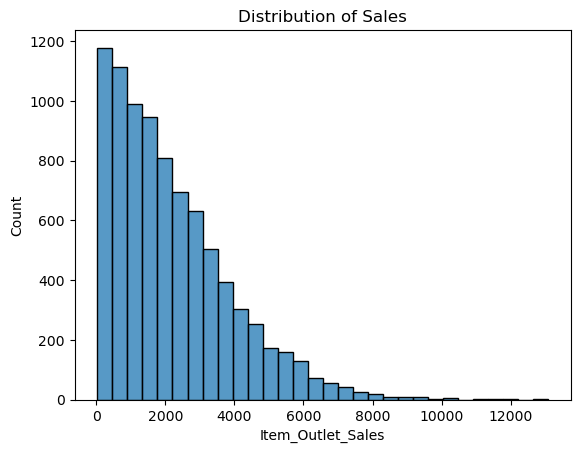

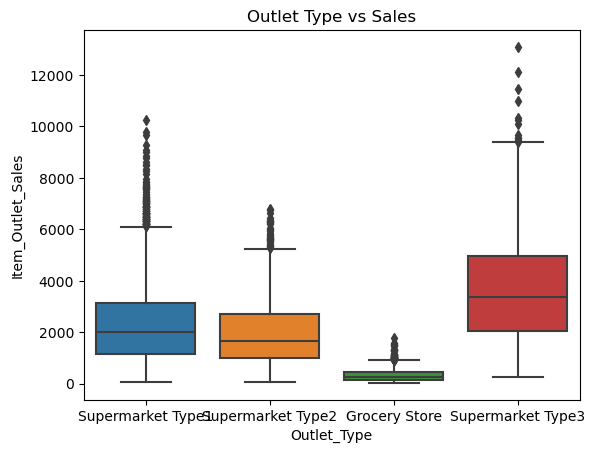

In [8]:
# Summary statistics
print(data.describe())

# Exploring missing values
print(data.isnull().sum())

# Visualizations
sns.histplot(data['Item_Outlet_Sales'], bins=30)
plt.title("Distribution of Sales")
plt.show()

sns.boxplot(x='Outlet_Type', y='Item_Outlet_Sales', data=data)
plt.title("Outlet Type vs Sales")
plt.show()

In [9]:
# Handling missing values
data['Item_Weight'].fillna(data['Item_Weight'].median(), inplace=True)
data['Outlet_Size'].fillna('Medium', inplace=True)  # Assuming medium size as default

# Checking for duplicates (none expected due to unique IDs)
print(data.duplicated().sum())

# Encoding categorical variables
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({
    'low fat': 'Low Fat', 'LF': 'Low Fat', 'reg': 'Regular'
})

# Mapping categories
categorical_vars = ['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
                    'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']
data = pd.get_dummies(data, columns=categorical_vars)

0


In [10]:
# Creating new feature: Outlet_Age
data['Outlet_Age'] = 2024 - data['Outlet_Establishment_Year']

# Drop the original year column
data.drop(['Outlet_Establishment_Year', 'Item_Identifier'], axis=1, inplace=True)

# Check the transformed data
data.head()

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,...,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Age
0,9.30,0.016047,249.8092,3735.1380,True,False,False,False,False,False,...,True,False,True,False,False,False,True,False,False,25
1,5.92,0.019278,48.2692,443.4228,False,True,False,False,False,False,...,True,False,False,False,True,False,False,True,False,15
2,17.50,0.016760,141.6180,2097.2700,True,False,False,False,False,False,...,True,False,True,False,False,False,True,False,False,25
3,19.20,0.000000,182.0950,732.3800,False,True,False,False,False,False,...,True,False,False,False,True,True,False,False,False,26
4,8.93,0.000000,53.8614,994.7052,True,False,False,False,False,False,...,False,False,False,False,True,False,True,False,False,37


We have covered data preparation and feature engineering two weeks ago. Now, it's time to do some predictive models.

## Model Building

## Task
Make a baseline model. Baseline models help us set a benchmark to gauge the performance of our future models. If your new model is below the baseline, something has gone wrong, and you should check your data.

To make a baseline model, run a simple regression model without altering the default parameters in sklearn. 

In [11]:
# Splitting data into features and target
X = data.drop(['Item_Outlet_Sales'], axis=1)
y = data['Item_Outlet_Sales']

# Splitting into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Baseline model using Linear Regression
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)
y_pred_baseline = baseline_model.predict(X_test)

# Evaluate baseline model
baseline_rmse = mean_squared_error(y_test, y_pred_baseline, squared=False)
baseline_r2 = r2_score(y_test, y_pred_baseline)

print(f"Baseline Model RMSE: {baseline_rmse:.2f}")
print(f"Baseline Model R^2: {baseline_r2:.2f}")

Baseline Model RMSE: 1069.36
Baseline Model R^2: 0.58


c:\Users\16476\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Task
Split your data in 80% train set and 20% test set.

## Task
Use grid_search to find the best value of the parameter `alpha` for Ridge and Lasso regressions from `sklearn`.

## Task
Using the model from grid_search, predict the values in the test set and compare against your benchmark.